In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import scipy
from scipy.sparse import csc_matrix
from collections import defaultdict
from os import listdir
import matplotlib.pyplot as plt
import sys
import gc
%matplotlib inline

In [2]:
with open('./../PickleFiles/num_to_ind_shot.pkl','r') as pickleFile:
    num_to_ind = pickle.load(pickleFile)

with open('./../PickleFiles/ind_to_num_shot.pkl','r') as pickleFile:
    ind_to_num = pickle.load(pickleFile)
    
with open('./../PickleFiles/player_names.pkl','r') as pickleFile:
    num_to_name = pickle.load(pickleFile)

with open('./../PickleFiles/tourn_order.pkl','r') as pickleFile:
    tourn_order = pickle.load(pickleFile)
    
name_to_num = {value:key for key,value in num_to_name.iteritems()}

In [3]:
rdata = pd.read_csv('./../data/round.csv')

In [4]:
cols = ['Year','Permanent_Tournament_#']
data = pd.concat([pd.read_csv('./../data/%d.csv' % (year))[cols] for year in range(2003,2017)])

In [5]:
data = pd.concat([data[(data.Year==year) & (data['Permanent_Tournament_#']==tourn)] 
                  for year,tourn in tourn_order])
tups = data.drop_duplicates(['Year','Permanent_Tournament_#'])[['Year','Permanent_Tournament_#']].values.tolist()

In [6]:
data = None
gc.collect()

25

In [7]:
tournament_groups = {tuple(tup):u/4 for u,tup in enumerate(tups)}

In [8]:
cats = ['tee3','tee45','green0','green5','green10','green20','rough0','rough90',
        'rough375','fairway0','fairway300','fairway540','bunker','other']

Selecting most predictive for first 50 tournament groups

In [565]:
mypath = './../ranks/'
corrs = defaultdict(list)
for path in [f for f in listdir(mypath)]:
    if len([f for f in listdir(mypath+path)])!=28:
        continue
    ratings_adam = {}
    for cat in cats:
        ratings_adam[cat] = np.load('%s%s/%s_ranks.npy' % (mypath,path,cat))
    preds,outcomes = defaultdict(list),defaultdict(list)
    for year,tourn in tups:
        tournament_group = tournament_groups[(year,tourn)]
        if tournament_group<38 or tournament_group>87:
            continue
        rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
        players = pd.unique(rtourn.Player_Number)
        finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
        finishing_positions = np.array([finishing_positions[player] for player in players])
        players = [num_to_ind[player] for player in players]
        for cat in cats:
            ratings = ratings_adam[cat][players,tournament_group-1]
            nulls = np.isnan(ratings)
            if np.all(nulls):
                continue
            ranking = pd.Series(ratings[~nulls]).rank(ascending=False,pct=True)
            outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
            preds[cat].extend(ranking.tolist())
            outcomes[cat].extend(outcome.tolist())
    for cat in cats:
        corrs[cat].extend([(path,np.corrcoef(preds[cat],outcomes[cat])[0,1])])
ratings_adam = {}
for cat in corrs:
    print cat
    for params,corr in sorted(corrs[cat],key=lambda x: x[1],reverse=True):
        print params,corr
    best = sorted(corrs[cat],key=lambda x: x[1],reverse=True)[0][0]
    ratings_adam[cat] = np.load('%s%s/%s_ranks.npy' % (mypath,best,cat))

green5
ranks-300-0.3-0.55-0.6-0.999-23.5 0.040199420628
ranks-300-0.3-0.55-0.6-0.999-22.5 0.0401702805254
ranks-300-0.3-0.55-0.6-0.999-21.5 0.0400886125223
ranks-300-0.3-0.55-0.6-0.999-20.5 0.0397643605746
ranks-300-0.3-0.55-0.6-0.999-16 0.0394354347412
ranks-300-0.23-0.15-0.7-0.999-17 0.039411632278
ranks-300-0.23-0.15-0.7-0.999-19 0.0393908931371
ranks-300-0.23-0.4-0.7-0.99-15 0.0389863335795
ranks-300-0.23-0.15-0.7-0.99-15 0.0389251141944
ranks-300-0.23-0.15-0.95-0.99-15 0.0387144342817
ranks-300-0.23-0.4-0.7-0.9-15 0.0386813559465
ranks-300-0.23-0.4-0.95-0.99-15 0.0386728662809
ranks-300-0.23-0.15-0.7-0.9-15 0.0385332604993
ranks-300-0.23-0.4-0.95-0.9-15 0.0384378477922
ranks-300-0.23-0.15-0.95-0.9-15 0.0383056709959
ranks-300-0.66-0.4-0.7-0.99-15 0.0376338818437
ranks-300-0.23-0.15-0.7-0.999-13 0.037567788231
ranks-300-0.66-0.4-0.7-0.9-15 0.0374412428512
ranks-300-0.66-0.15-0.7-0.99-15 0.0374203586356
ranks-300-0.66-0.15-0.7-0.9-15 0.0372175723679
ranks-300-0.3-0.55-0.6-0.999-12 0

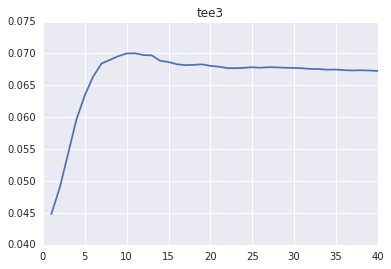

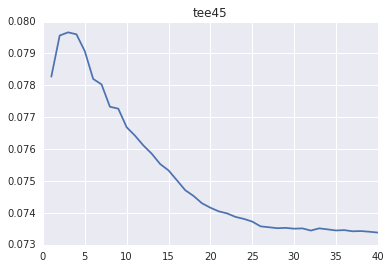

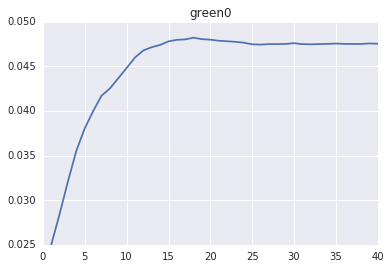

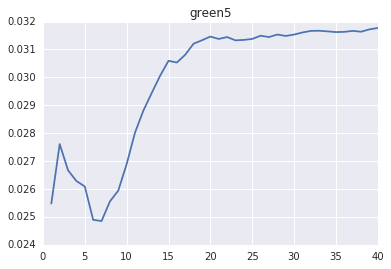

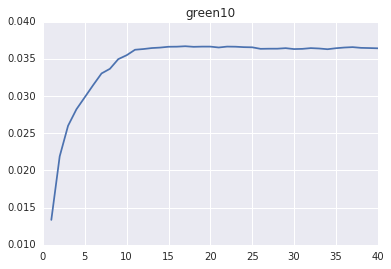

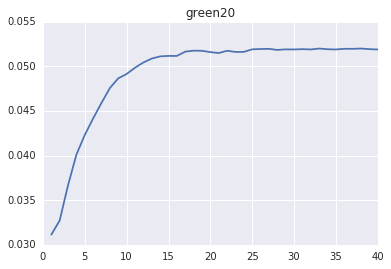

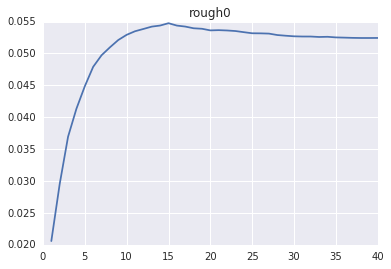

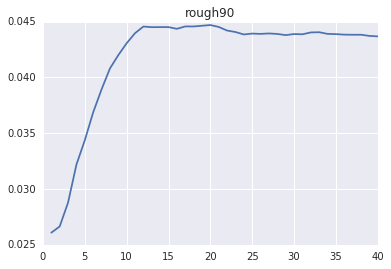

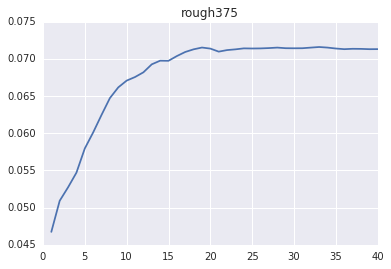

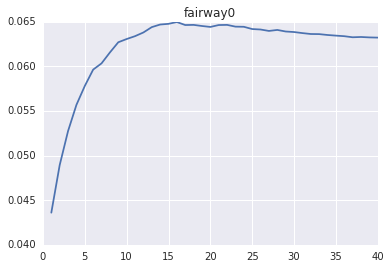

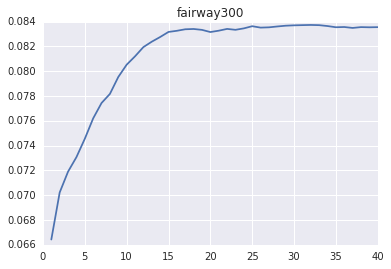

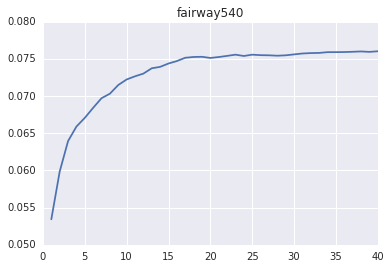

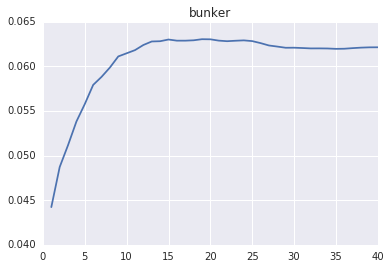

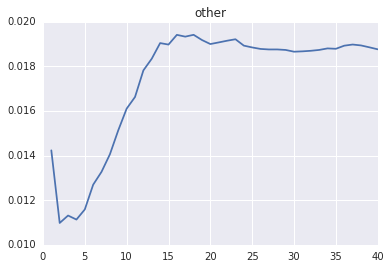

In [564]:
for cat in cats:
    plt.figure()
    x,y = zip(*corrs[cat])
    plt.plot(x,y)
    plt.title(cat)

In [563]:
mypath = './../Broadie_Aves'
corrs = defaultdict(list)
for BETA in range(1,41):
    ratings_broadie = {}
    for cat in cats:
        ratings_broadie[cat] = np.load('%s/%s_%d.npy' % (mypath,cat,BETA))
    preds,outcomes = defaultdict(list),defaultdict(list)
    for year,tourn in tups:
        tournament_group = tournament_groups[(year,tourn)]
        if tournament_group<38 or tournament_group>87:
            continue
        rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
        players = pd.unique(rtourn.Player_Number)
        finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
        finishing_positions = np.array([finishing_positions[player] for player in players])
        players = [num_to_ind[player] for player in players]
        for cat in cats:
            ratings = ratings_broadie[cat][players,tournament_group]
            nulls = np.isnan(ratings)
            if np.all(nulls):
                continue
            ranking = pd.Series(ratings[~nulls]).rank(ascending=False,pct=True)
            outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
            preds[cat].extend(ranking.tolist())
            outcomes[cat].extend(outcome.tolist())
    for cat in cats:
        corrs[cat].extend([(BETA,np.corrcoef(preds[cat],outcomes[cat])[0,1])])
ratings_broadie = {}
for cat in corrs:
    print cat
    for BETA,corr in sorted(corrs[cat],key=lambda x: x[1],reverse=True):
        print BETA,corr
    best = sorted(corrs[cat],key=lambda x: x[1],reverse=True)[0][0]
    ratings_broadie[cat] = np.load('%s/%s_%d.npy' % (mypath,cat,best))

green5
40 0.0317716360923
39 0.0317207592068
33 0.0316719136869
37 0.0316672127529
32 0.0316661003748
34 0.0316495741865
38 0.0316376385913
36 0.0316312559213
35 0.0316248614455
31 0.0316097812565
28 0.0315363937395
30 0.0315347075103
26 0.0314938907975
29 0.0314855480917
20 0.0314634811306
22 0.0314468860311
27 0.0314458976539
25 0.0313786816325
21 0.0313781667369
24 0.0313437610273
19 0.0313314676439
23 0.0313278376749
18 0.0312082453963
17 0.0308130002117
15 0.0305943848488
16 0.0305329366915
14 0.0300602961398
13 0.0294440052564
12 0.0288114120834
11 0.0280219307606
2 0.027610725241
10 0.026891440089
3 0.0266692044507
4 0.0262857021588
5 0.0260902941637
9 0.0259428813514
8 0.0255541383671
1 0.0254797712005
6 0.0248961157014
7 0.0248518309322
fairway300
32 0.0837295994037
31 0.0837147990975
33 0.083712828297
30 0.083698942725
29 0.0836686456947
34 0.0836412293389
25 0.083628325679
28 0.0836070849776
36 0.0835638355377
38 0.083555481952
40 0.0835527089171
35 0.0835441471335
39 0.0835

Test set predictions

In [566]:
preds_a,preds_b,outcomes = defaultdict(list),defaultdict(list),defaultdict(list)
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group<88:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = np.array([num_to_ind[player] for player in players])
    for cat in cats:
        ratings_a = ratings_adam[cat][players,tournament_group-1]
        ratings_b = ratings_broadie[cat][players,tournament_group]
        nulls = np.logical_or(np.isnan(ratings_a),np.isnan(ratings_b))
        if np.all(nulls):
            continue
        rankings_a = pd.Series(ratings_a[~nulls]).rank(ascending=False,pct=True)
        rankings_b = pd.Series(ratings_b[~nulls]).rank(ascending=False,pct=True)
        outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
        preds_a[cat].extend(rankings_a.tolist())
        preds_b[cat].extend(rankings_b.tolist())
        outcomes[cat].extend(outcome.tolist())

Correlation tests

In [567]:
corrs = {cat:np.corrcoef(preds_b[cat],outcomes[cat])[0,1] for cat in cats}

In [568]:
ps_and_os = {}
for cat in cats:
    ps_and_os[cat] = pd.DataFrame({'Predictions_Adam':preds_a[cat],
                                   'Predictions_Broadie':preds_b[cat],
                                   'Outcome':outcomes[cat]})

In [569]:
for cat in cats:
    print
    print cat
    print len(preds_a[cat])
    assert len(preds_a[cat])==len(preds_b[cat])
    print 'Adam Corr = ' + str(np.corrcoef(preds_a[cat],outcomes[cat])[0,1])
    print 'Broadie Corr = ' + str(np.corrcoef(preds_b[cat],outcomes[cat])[0,1])
    print 


tee3
24147
Adam Corr = 0.0982799448857
Broadie Corr = 0.0883652772141


tee45
24095
Adam Corr = 0.116846431357
Broadie Corr = 0.106354598938


green0
24147
Adam Corr = 0.0454800072477
Broadie Corr = 0.0366799770574


green5
24147
Adam Corr = 0.0246730357778
Broadie Corr = 0.0169253286494


green10
24147
Adam Corr = 0.0446121914546
Broadie Corr = 0.0334820350513


green20
24147
Adam Corr = 0.0458706375755
Broadie Corr = 0.0391544843399


rough0
24135
Adam Corr = 0.0447105076368
Broadie Corr = 0.0350812080657


rough90
24123
Adam Corr = 0.0512957353336
Broadie Corr = 0.0473352937577


rough375
24147
Adam Corr = 0.0876739583505
Broadie Corr = 0.0726519657294


fairway0
24143
Adam Corr = 0.0712968893264
Broadie Corr = 0.0691534469134


fairway300
24146
Adam Corr = 0.0785977758151
Broadie Corr = 0.0723335161742


fairway540
24139
Adam Corr = 0.0901446085462
Broadie Corr = 0.0826678701186


bunker
24143
Adam Corr = 0.0445270746206
Broadie Corr = 0.0384112043822


other
14257
Adam Corr = 0.0

In [570]:
def confidence_interval(df,its):
    corrs_adam,corrs_broadie = [],[]
    for _ in range(its):
        df_ = df.sample(frac=1,replace=True)
        corrs_adam.append(np.corrcoef(df_.Predictions_Adam,df_.Outcome)[0,1])
        corrs_broadie.append(np.corrcoef(df_.Predictions_Broadie,df_.Outcome)[0,1])
    return corrs_adam,corrs_broadie

In [571]:
for cat in cats:
    corrs_adam,corrs_broadie = confidence_interval(ps_and_os[cat],1000)
    print cat
    print 'adam',np.mean(corrs_adam),(np.mean(corrs_adam)-np.std(corrs_adam),np.mean(corrs_adam)+np.std(corrs_adam))
    print 'broadie',np.mean(corrs_broadie),(np.mean(corrs_broadie)-np.std(corrs_broadie),np.mean(corrs_broadie)+np.std(corrs_broadie))

tee3
adam 0.0981512611834 (0.091676605821807575, 0.10462591654506755)
broadie 0.0882843203379 (0.08181409890333069, 0.094754541772498063)
tee45
adam 0.11703404082 (0.11095042049217926, 0.1231176611484765)
broadie 0.106426125685 (0.10031995475340208, 0.11253229661631409)
green0
adam 0.0454423403763 (0.038997453613535502, 0.051887227139153849)
broadie 0.0365757386345 (0.030131949578508292, 0.043019527690537351)
green5
adam 0.0249538080691 (0.018414114829781, 0.031493501308506866)
broadie 0.0173207949 (0.010718676401937601, 0.023922913398033391)
green10
adam 0.0449324104875 (0.038222555627201789, 0.051642265347716466)
broadie 0.0337310910015 (0.027041846559657173, 0.040420335443288657)
green20
adam 0.0457456374188 (0.039397453363707667, 0.052093821473885742)
broadie 0.0389824079849 (0.032665093032443006, 0.04529972293741847)
rough0
adam 0.044814075089 (0.038173136990460807, 0.051455013187447718)
broadie 0.0351638892109 (0.028641307328963299, 0.041686471092918835)
rough90
adam 0.0517228944

In [330]:
sys.path.insert(0, '/home/ubuntu/CorrelationStats/')
import corrstats

(-0.89127990476054142, 0.37491851749125571)
(1.0171097212822693, 0.30910123623869312)


In [572]:
for cat in cats:
    xy = np.corrcoef(ps_and_os[cat].Outcome,ps_and_os[cat].Predictions_Adam)[0,1]
    xz = np.corrcoef(ps_and_os[cat].Outcome,ps_and_os[cat].Predictions_Broadie)[0,1]
    yz = np.corrcoef(ps_and_os[cat].Predictions_Adam,ps_and_os[cat].Predictions_Broadie)[0,1]
    print cat
    print xy,xz,yz
    print corrstats.dependent_corr(xy,xz,yz,len(ps_and_os[cat]),
                                    twotailed=False, conf_level=0.95, method='steiger')
    print corrstats.dependent_corr(xy,xz,yz,len(ps_and_os[cat]),
                                    twotailed=False, conf_level=0.95, method='zou')
    print

tee3
0.0982799448857 0.0883652772141 0.941851188881
(4.5398087229593047, 2.8288522917474523e-06)
(0.0056325239563371574, 0.014196596755150313)

tee45
0.116846431357 0.106354598938 0.927241265855
(4.2985087601542116, 8.6312985503322892e-06)
(0.0057062533357474391, 0.015277211771734436)

green0
0.0454800072477 0.0366799770574 0.956771064788
(4.6564626410068932, 1.6170009045080036e-06)
(0.0050944214835447641, 0.012505291832566465)

green5
0.0246730357778 0.0169253286494 0.928975694087
(3.195570692850167, 0.00069867034984194554)
(0.0029948666009875962, 0.012500094534426905)

green10
0.0446121914546 0.0334820350513 0.902098945249
(3.9127527732119867, 4.5749979077469582e-05)
(0.005553266958025856, 0.016706311757029805)

green20
0.0458706375755 0.0391544843399 0.871297209437
(2.059076434394675, 0.019748808778267235)
(0.00032288812937218084, 0.013108907203212224)

rough0
0.0447105076368 0.0350812080657 0.776193723967
(2.238050806525536, 0.012613413391868722)
(0.0011958218924570576, 0.018061781

Regressions analysis

In [537]:
inds_to_plot = [num_to_ind[name_to_num[name]] for name in ['Woods, Tiger','Mickelson, Phil']]

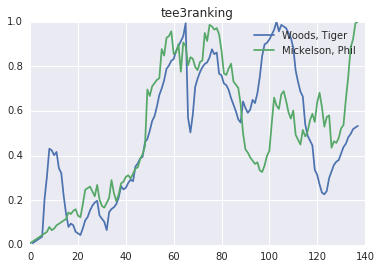

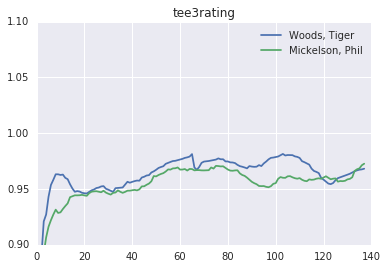

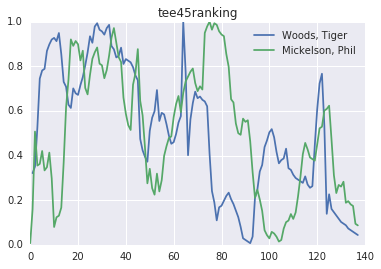

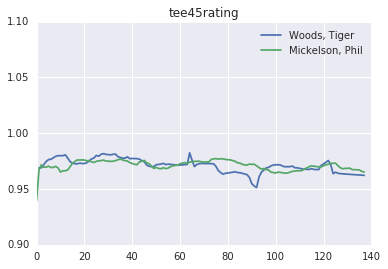

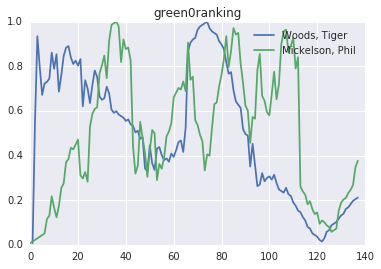

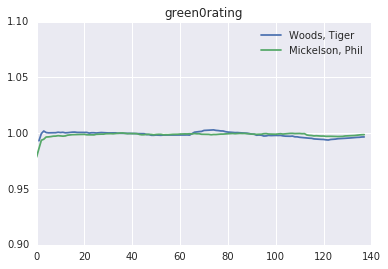

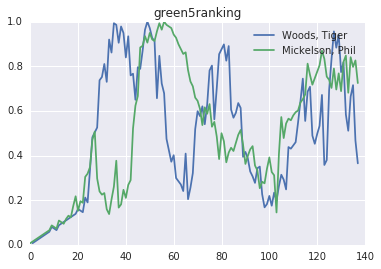

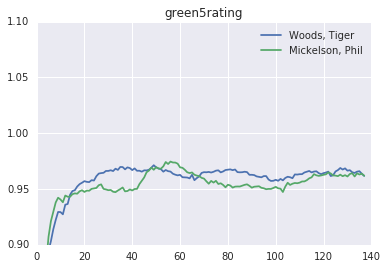

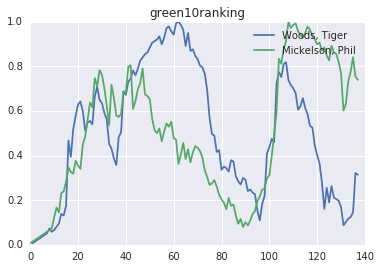

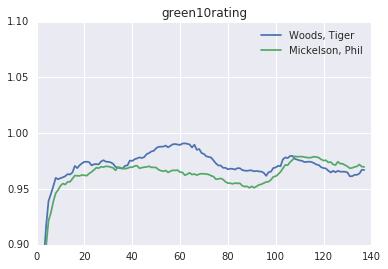

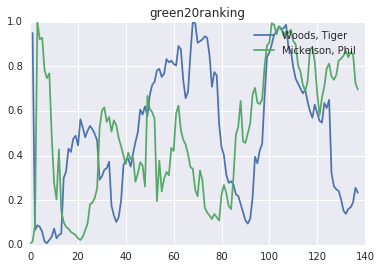

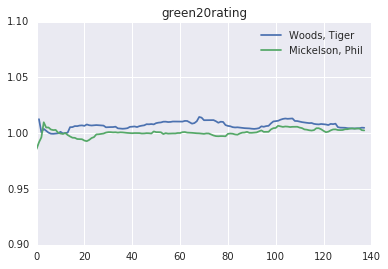

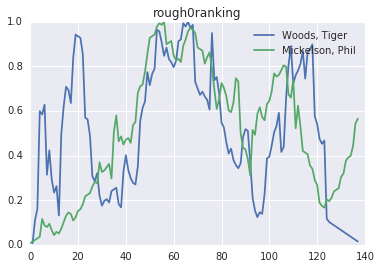

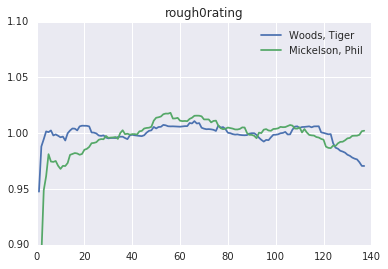

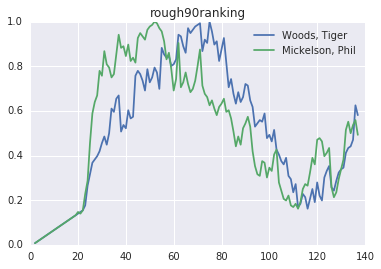

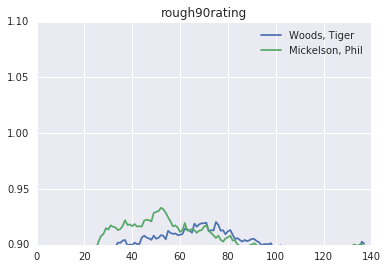

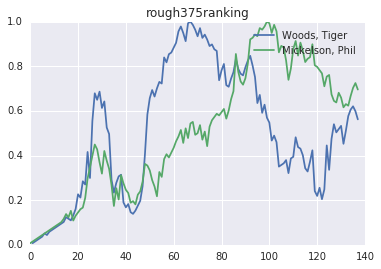

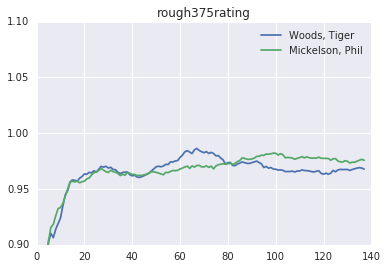

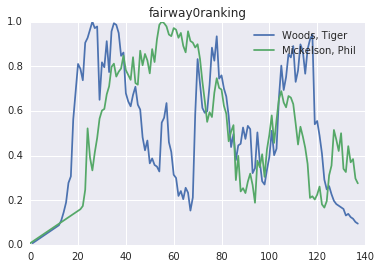

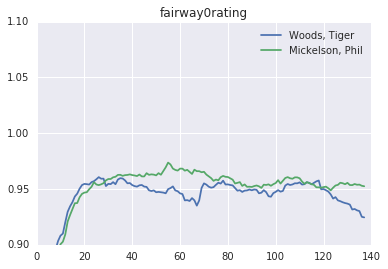

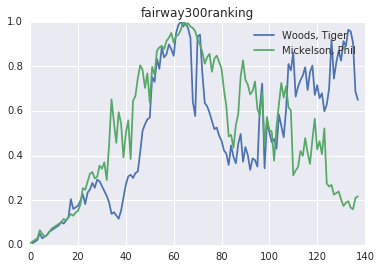

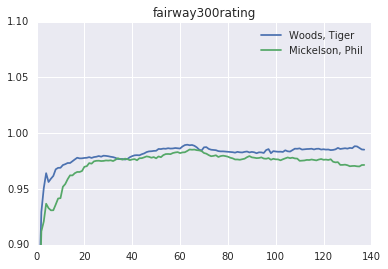

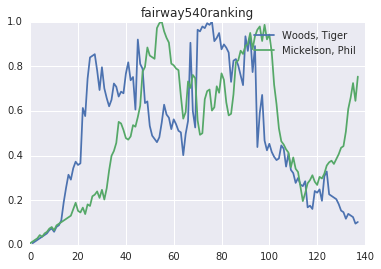

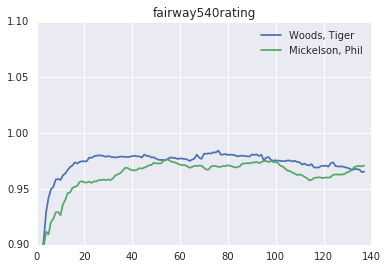

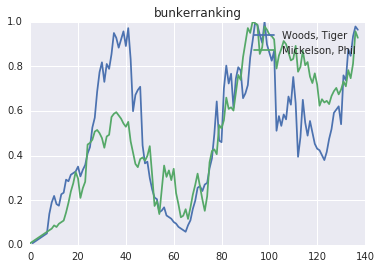

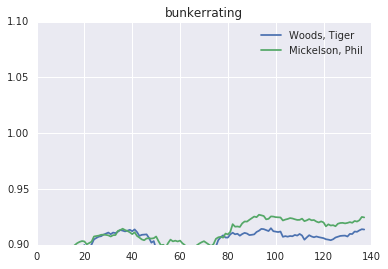

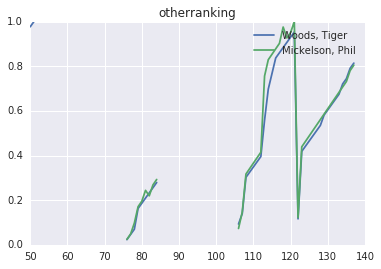

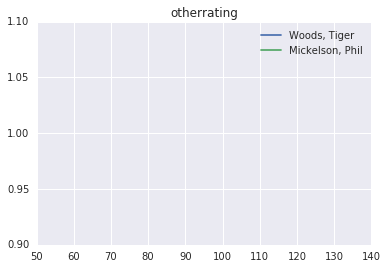

In [543]:
for cat in cats:
    plt.figure()
    for ind in inds_to_plot:
        ranking = pd.Series(ratings_adam[cat][ind,:]).rank(ascending=True,pct=True)
        plt.plot(np.arange(ratings_adam[cat].shape[1]),ranking,label=num_to_name[ind_to_num[ind]])
    plt.legend()
    plt.title(cat+'ranking')
    plt.show()
    plt.close()
    
    plt.figure()
    for ind in inds_to_plot:
        rating = ratings_adam[cat][ind,:]
        plt.plot(np.arange(ratings_adam[cat].shape[1]),rating,label=num_to_name[ind_to_num[ind]])
    plt.legend()
    plt.title(cat+'rating')
    plt.ylim(.9,1.1)
    plt.show()
    plt.close()

In [557]:
preds_a,preds_b,outcomes = defaultdict(list),defaultdict(list),[]
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group<88:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = np.array([num_to_ind[player] for player in players])
    nulls = [False]*players.shape[0]
    for cat in cats[:-1]:
        ratings_a = ratings_adam[cat][players,tournament_group-1]
        ratings_b = ratings_broadie[cat][players,tournament_group]
        nulls_ = np.logical_or(np.isnan(ratings_a),np.isnan(ratings_b))
        nulls = np.logical_or(nulls,nulls_)
    for cat in cats[:-1]:
        ratings_a = ratings_adam[cat][players,tournament_group-1][~nulls]
        ratings_b = ratings_broadie[cat][players,tournament_group][~nulls]
        rankings_a = pd.Series(ratings_a).rank(ascending=False,pct=True)
        rankings_b = pd.Series(ratings_b).rank(ascending=False,pct=True)
        preds_a[cat].extend(rankings_a.tolist())
        preds_b[cat].extend(rankings_b.tolist())
    outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
    print len(outcome),tournament_group
    outcomes.extend(outcome.tolist())

114 88
141 88
149 88
124 88
73 89
148 89
119 89
97 89
69 90
30 90
127 90
128 90
124 91
127 91
27 91
121 91
135 92
149 92
125 92
149 92
137 93
137 93
64 93
139 93
115 94
137 94
128 94
142 94
147 95
148 95
137 95
147 95
122 96
115 96
145 96
148 96
116 97
148 97
149 97
118 97
145 98
65 98
142 98
121 98
97 99
70 99
30 99
128 99
130 100
130 100
128 100
30 100
118 101
138 101
131 101
120 101
154 102
134 102
140 102
57 102
151 103
129 103
149 103
146 103
138 104
151 104
153 104
141 104
150 105
128 105
116 105
146 105
151 106
126 106
146 106
145 106
118 107
140 107
66 107
154 107
119 108
100 108
70 108
30 108
118 109
122 109
122 109
30 109
134 110
152 110
149 110
130 110
153 111
135 111
138 111
63 111
140 112
113 112
133 112
137 112
127 113
152 113
151 113
142 113
150 114
121 114
117 114
140 114
149 115
119 115
150 115
144 115
141 116
65 116
125 116
151 116
121 117
92 117
66 117
29 117
129 118
128 118
114 118
111 118
33 119
135 119
152 119
129 119
152 120
153 120
139 120
138 120
68 121
140 121

In [558]:
X_sgttf = np.column_stack([preds_b[cat] for cat in cats[:-1]])
X_network = np.column_stack([preds_a[cat] for cat in cats[:-1]])
y = np.array(outcomes)

In [559]:
X_sgttf.shape,X_network.shape,y.shape

((24044, 13), (24044, 13), (24044,))

In [560]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score

In [561]:
ols = LinearRegression()

In [562]:
cross_val_score(ols,X_sgttf,y,cv=30).mean(),cross_val_score(ols,X_network,y,cv=30).mean()

(0.034193110929220678, 0.035143149057829226)

Other regressions using just the Network method

In [72]:
with open('./../PickleFiles/course_profiles.pkl','r') as pickleFile:
    course_profiles = pickle.load(pickleFile)

with open('./../PickleFiles/course_order.pkl','r') as pickleFile:
    course_order = pickle.load(pickleFile)

cat_map = {''.join([c for c in name.lower() if c!='-']):name for name in course_profiles.keys()}

In [437]:
preds,outcomes = defaultdict(list),[]
course_profs = defaultdict(list)
years,tourns = [],[]
for year,tourn in tups:
    tournament_group = tournament_groups[(year,tourn)]
    if tournament_group<88:
        continue
    rtourn = rdata[(rdata.Tournament_Year==year) & (rdata['Permanent_Tournament_#']==tourn)]
    courses = pd.unique(rtourn['Course_#'])
    players = pd.unique(rtourn.Player_Number)
    finishing_positions = rtourn.groupby('Player_Number').Finishing_Position.mean().to_dict()
    finishing_positions = np.array([finishing_positions[player] for player in players])
    players = np.array([num_to_ind[player] for player in players])
    nulls = np.array([False]*players.shape[0])
    for cat in cats[:-1]:
        ratings = ratings_adam[cat][players,tournament_group-1]
        nulls = np.logical_or(nulls,np.isnan(ratings))
    for cat in cats[:-1]:
        ratings = ratings_adam[cat][players,tournament_group-1][~nulls]
        rankings = pd.Series(ratings).rank(ascending=False,pct=True)
        preds[cat].extend(rankings.tolist())
        course_profs[cat].extend([np.mean([course_profiles[cat_map[cat]][course_order.index(course),tournament_group] 
                                           for course in courses])]*rankings.shape[0])
    outcome = pd.Series(finishing_positions[~nulls]).rank(pct=True)
    outcomes.extend(outcome.tolist())
    years.extend([year]*outcome.shape[0])
    tourns.extend([tourn]*outcome.shape[0])

In [438]:
d = {cat+'_rank':preds[cat] for cat in cats[:-1]}
d.update({cat+'_importance':course_profs[cat] for cat in cats[:-1]})
d.update({'Outcome':outcomes,'Year':years,'Tournament':tourns})
mat = pd.DataFrame(d)

In [54]:
np.corrcoef(mat.drop(['Year','Tournament'],axis=1).values)

MemoryError: 

In [237]:
groups = {tuple(tup):u for u,tup in enumerate(mat[['Tournament','Year']].drop_duplicates().values.tolist())}
groups = np.array([groups[tuple(tup)] for tup in mat[['Tournament','Year']].values.tolist()])
n_groups = len(pd.unique(groups))

In [439]:
X = mat[[col for col in mat.columns if 'rank' in col]].values
y = mat.Outcome.values

In [449]:
X = np.hstack((mat[[col for col in mat.columns if 'rank' in col]].values,
               np.multiply(mat[[col for col in mat.columns if 'rank' in col]].values,
                           mat[[col for col in mat.columns if 'importance' in col]].values)))
y = mat.Outcome.values

In [450]:
from sklearn.linear_model import LassoCV,RidgeCV

In [451]:
rcv.fit(X,y)

RidgeCV(alphas=array([  1.00000e-05,   3.59381e-05,   1.29155e-04,   4.64159e-04,
         1.66810e-03,   5.99484e-03,   2.15443e-02,   7.74264e-02,
         2.78256e-01,   1.00000e+00]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=False,
    scoring=None, store_cv_values=True)

In [452]:
rcv.cv_values_.mean(0)

array([ 0.08011617,  0.08011617,  0.08011617,  0.08011615,  0.08011611,
        0.08011594,  0.08011536,  0.08011339,  0.0801076 ,  0.08009479])

In [453]:
for col,coef in sorted(zip([col for col in mat.columns if '_rank' in col],rcv.coef_),key=lambda x: x[1])[::-1]:
    print col,coef

tee45_rank 0.0784227681245
green10_rank 0.0774886750685
green0_rank 0.0611639389567
tee3_rank 0.0520549333138
fairway300_rank 0.0506583304915
rough375_rank 0.0402129431372
fairway0_rank 0.0354005226466
rough0_rank 0.0284595802312
fairway540_rank 0.0237387440325
rough90_rank 0.0216585712191
bunker_rank 0.0199474341284
green20_rank 0.0158628832721
green5_rank 0.00877962457956


In [454]:
pd.Series(rcv.predict(X)).describe()

count    24044.000000
mean         0.504097
std          0.055188
min          0.312114
25%          0.467663
50%          0.505595
75%          0.541207
max          0.732678
dtype: float64

In [455]:
lcv = LassoCV(eps=0.001, n_alphas=100, alphas=None, 
              fit_intercept=True, normalize=True, 
              precompute='auto', max_iter=1000, tol=0.0001, 
              copy_X=True, cv=None, verbose=False)

In [456]:
lcv.fit(X,y)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

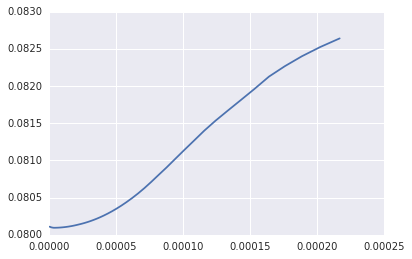

In [458]:
plt.plot(lcv.alphas_,lcv.mse_path_.mean(1))

In [457]:
for col,coef in sorted(zip([col for col in mat.columns if '_rank' in col],lcv.coef_),key=lambda x: x[1])[::-1]:
    print col,coef

tee45_rank 0.0818765833247
green0_rank 0.0492441721988
tee3_rank 0.0461537926737
fairway300_rank 0.0351016515082
rough375_rank 0.0328702473326
fairway0_rank 0.0321158069853
green10_rank 0.0261320466308
rough0_rank 0.0252339787945
green20_rank 0.0235737943596
rough90_rank 0.0195988428318
bunker_rank 0.0186898669033
fairway540_rank 0.014732273748
green5_rank 0.00932833152918


In [446]:
for col,coef in sorted(zip([col for col in mat.columns if '_rank' in col],lcv.coef_),key=lambda x: x[1])[::-1]:
    print col,coef

tee45_rank 0.115458431576
green0_rank 0.0498420346678
tee3_rank 0.0464454978271
fairway0_rank 0.0364075916999
fairway300_rank 0.035492206679
rough375_rank 0.0330417682415
green20_rank 0.0285378797918
rough90_rank 0.0273870768121
green10_rank 0.0264376001186
rough0_rank 0.0257131660192
bunker_rank 0.0202800536568
fairway540_rank 0.0149623000308
green5_rank 0.00977955338543


In [447]:
pd.Series(lcv.predict(X)).describe()

count    24044.000000
mean         0.504097
std          0.054289
min          0.314359
25%          0.468297
50%          0.505575
75%          0.540667
max          0.725616
dtype: float64

In [448]:
pd.Series(np.abs(lcv.predict(X)-y)).describe()

count    24044.000000
mean         0.243701
std          0.143420
min          0.000013
25%          0.120920
50%          0.241293
75%          0.363063
max          0.661860
dtype: float64